# Autoencoder Anomaly Detection
Prototype an anomaly detection algorithm using autoencoders. Will be using fashion-MNIST data set. "Hands-On Machine Learning", by Aurelien Geron, is the basis for much of the code. https://github.com/ageron/handson-ml2

In [1]:
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorboard

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Tensorboard version:', tensorboard.__version__)

%matplotlib inline

TensorFlow version:  2.0.0
Keras version:  2.2.4-tf
Tensorboard version: 2.0.0


## 1.0 Load and Prepare Data

In [2]:
# load fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist
(X_train_all, y_train_all), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
# class names
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [4]:
# split the data between train and validation sets, and scale
# also have a "slimmed down" data set that has only positive classes that will be used to train the autoencoder
X_val, X_val_slim, X_train_slim = X_train_all[:5000] / 255.0, \
                                        X_train_all[5000:10000] / 255.0, \
                                        X_train_all[10000:] / 255.0
y_val, y_val_slim, y_train_slim = y_train_all[:5000],y_train_all[5000:10000], y_train_all[10000:]

# also scale the X_test
X_test = X_test / 255.0

print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('X_val_slim shape:', X_val_slim.shape)
print('y_val_slim shape:', y_val_slim.shape)
print('X_train_slim shape:', X_train_slim.shape)
print('y_train_slim shape:', y_train_slim.shape)

X_val shape: (5000, 28, 28)
y_val shape: (5000,)
X_val_slim shape: (5000, 28, 28)
y_val_slim shape: (5000,)
X_train_slim shape: (50000, 28, 28)
y_train_slim shape: (50000,)


In [5]:
def remove_classes(class_to_remove, y_val_slim, X_val_slim):
    """Funciton to remove classes from train/val set"""
    
    # start with y_valid_slim
    index_to_delete = []
    for i, class_digit in enumerate(y_val_slim):
        if class_digit in class_to_remove:
            index_to_delete.append(i)

    y_val_slim = np.delete(y_val_slim, index_to_delete)
    X_val_slim = np.delete(X_val_slim, index_to_delete, axis=0)
    
    return X_val_slim, y_val_slim

In [6]:
# remove two classes from the X_train_all data set. We will categorize those two classes as "anomalous"
# will remove "T-shirt/top" (class 0) and "Pullover" (class 2)
class_to_remove = np.array([0, 2],dtype='uint8')

X_val_slim, y_val_slim = remove_classes(class_to_remove, y_val_slim, X_val_slim)
X_train_slim, y_train_slim = remove_classes(class_to_remove, y_train_slim, X_train_slim)

print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('X_val_slim shape:', X_val_slim.shape)
print('y_val_slim shape:', y_val_slim.shape)
print('X_train_slim shape:', X_train_slim.shape)
print('y_train_slim shape:', y_train_slim.shape)

X_val shape: (5000, 28, 28)
y_val shape: (5000,)
X_val_slim shape: (4003, 28, 28)
y_val_slim shape: (4003,)
X_train_slim shape: (39958, 28, 28)
y_train_slim shape: (39958,)


## 2.0 Sparse Autoencoder

We will build as sparse autoencoder. But first, we will build a vanilla stacked autoencoder as a comparison.

Andrew Ng has a good video of what a sparse autoencoder is: https://youtu.be/vfnxKO2rMq4

In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

Note: we are using sigmoid activations so that the activations all end up between 0 and 1. This will make visualizing the activations easier.

In [9]:
# plot the results
def plot_reconstructions(model, index_list, X_valid): 
    reconstructions = model.predict(X_valid)
    
    # get the length of index_list to set number of
    # images to plot
    n_images = len(index_list)

    # Plot a random sample
    fig, axes = plt.subplots(2, n_images,figsize=(n_images*1.5,3),dpi=150)
    # fig.suptitle('Digits for Sample %i' %num, size=15, x=0.2)

    for i in range(0, n_images):
        axes[0][i].imshow(np.reshape(X_valid[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[0][i].axis('off')
        axes[0][i].set_title(str(index_list[i]))
        axes[1][i].imshow(np.reshape(reconstructions[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[1][i].axis('off')
        
    plt.show()

We want to see how the activations behave with this simple stacked autoencoder.
- Using the validation data set, **what is the distribution of activations between 0 and 1?**
- Using the validation data set, **what are the average neuron activation values?**

In [10]:
# plots from https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_val_slim).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])


We will use KL Divergence to target the sparsity of 10%, rather than 0%

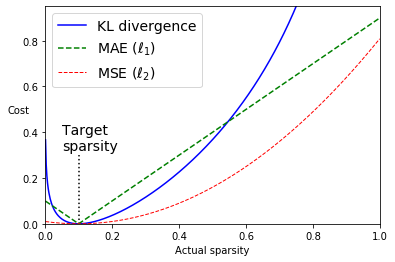

In [12]:
# plot the regulizers (from Geron book)
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.show()

In [13]:
# build custom regularizer for KL-Divergence
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))
    
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [42]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(),
              metrics=[rounded_accuracy])

# log_dir="logs/" + str('anom_') + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0,
#                                                       update_freq='epoch',profile_batch=0)

sparse_kl_encoder.summary()
sparse_kl_decoder.summary()



Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_29 (Dense)             (None, 300)               30300     
Total params: 108,800
Trainable params: 108,800
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_31 (Dense)             (None, 784)               79184     
________________________

In [43]:
history = sparse_kl_ae.fit(X_train_slim, X_train_slim, epochs=5,
                           validation_data=[X_val_slim, X_val_slim], callbacks=[])

Train on 39958 samples, validate on 4003 samples
Epoch 1/5
39958/39958 [==============================] - 4s 111us/sample - loss: 0.3196 - rounded_accuracy: 0.8926 - val_loss: 0.2871 - val_rounded_accuracy: 0.9200
Epoch 2/5
39958/39958 [==============================] - 4s 90us/sample - loss: 0.2796 - rounded_accuracy: 0.9269 - val_loss: 0.2746 - val_rounded_accuracy: 0.9308
Epoch 3/5
39958/39958 [==============================] - 4s 90us/sample - loss: 0.2702 - rounded_accuracy: 0.9354 - val_loss: 0.2672 - val_rounded_accuracy: 0.9382
Epoch 4/5
39958/39958 [==============================] - 4s 91us/sample - loss: 0.2650 - rounded_accuracy: 0.9403 - val_loss: 0.2635 - val_rounded_accuracy: 0.9413
Epoch 5/5
39958/39958 [==============================] - 4s 92us/sample - loss: 0.2617 - rounded_accuracy: 0.9434 - val_loss: 0.2606 - val_rounded_accuracy: 0.9447


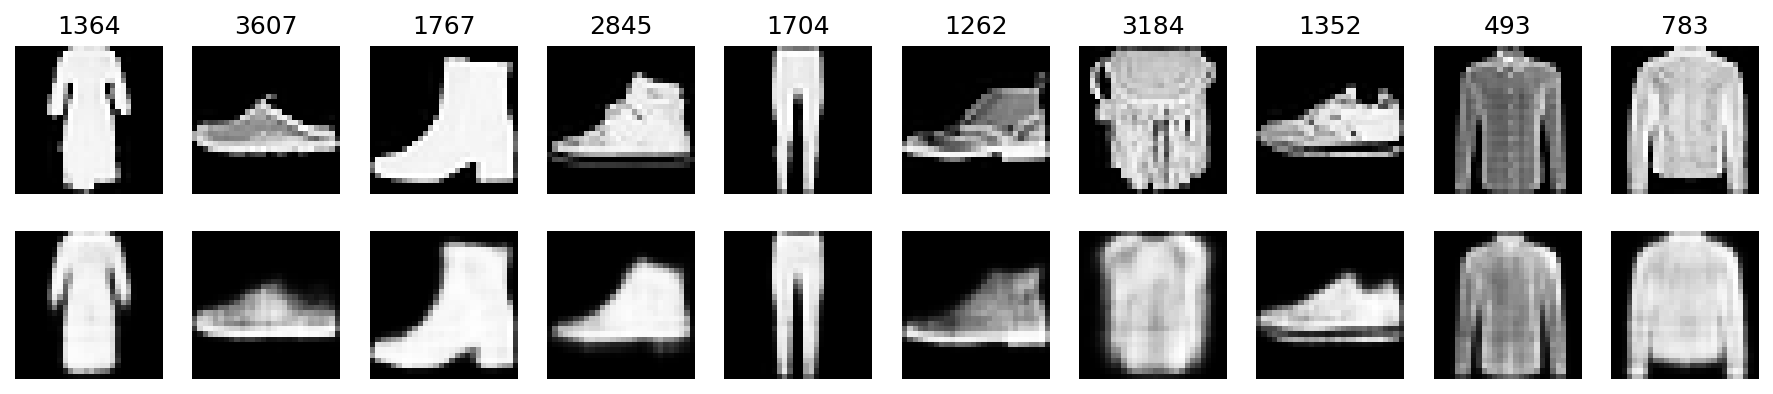

In [44]:
# plot a random number of items
import random
index_list = random.sample(range(0,len(X_val_slim)), 10)

plot_reconstructions(sparse_kl_ae, index_list, X_val_slim)

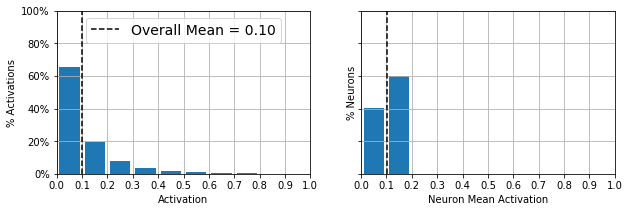

In [46]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()

In [47]:
recon_val_slim = sparse_kl_ae(X_val_slim).numpy()
recon_val_slim.shape

(4003, 28, 28)

In [91]:
# build a table with all the RMSE results from the reconstructions
# sewar is a package that has many image quality assement algos already developed,
# and it can be used as a good guide https://github.com/andrewekhalel/sewar
# However, we will calculate the RMSE across the whole numpy array and then
# put these in a pandas dataframe

def mse(X_val,recon_val):
    """Calculate MSE for images in X_val and recon_val"""
    
    # need to calculate mean across the rows, and then across the columns
    return np.mean(np.mean(np.square(X_val.astype('float32') - recon_val.astype('float32')),axis=1),axis=1)

def rmse(X_val,recon_val):
    """Calculate RMSE for images in X_val and recon_val"""
    return np.sqrt(mse(X_val, recon_val))

def euclidean_distance(X_val,recon_val):
    dist = np.linalg.norm(X_val - recon_val,axis=(1,2))
    return dist

# function that creates a pandas dataframe with the RMSE value, and the associated class
def create_df_reconstruction(rmse_val, y_val, metric, class_to_remove, threshold_val):
    df = pd.DataFrame(data=rmse_val, columns=[metric])
    
    # append the class values
    df['class'] = y_val
    
    # label anomolous class as 1, others as 0
    new_y_val = []
    for i in y_val:
        if i in class_to_remove:
            new_y_val.append(1)
        else:
            new_y_val.append(0)
    
    df['new_class'] = new_y_val
    
    # add prediction based on threshold
    df['prediction'] = np.where(df[metric] >= threshold_val,1,0)
    
    return df

In [92]:
class_to_remove = np.array([0, 2],dtype='uint8')

# euclidean distance measurements
eu_val_slim = euclidean_distance(X_val_slim,recon_val_slim)
eu_val_slim

array([2.41653158, 2.68438231, 2.54434024, ..., 2.8953415 , 3.32598574,
       2.30537253])

In [93]:
np.where(eu_val_slim > 3.99, 1,0)

array([0, 0, 0, ..., 0, 0, 0])

In [94]:
print(np.max(eu_val_slim))
print(np.percentile(eu_val_slim,90))

8.550554883355533
3.997250386865136


In [95]:
df = create_df_reconstruction(eu_val_slim, y_val_slim, "euclidean",class_to_remove, 3.99)
df.head()

,euclidean,class,new_class,prediction
0,2.416532,4,0,0
1,2.684382,7,0,0
2,2.544340,9,0,0
3,2.840876,9,0,0
4,3.055432,9,0,0


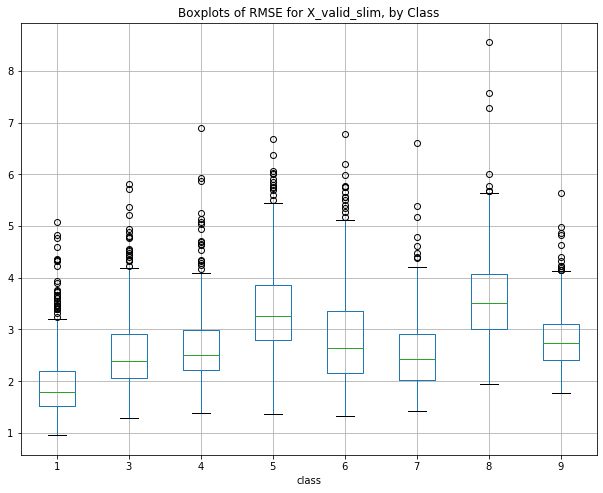

In [69]:
fig, ax = plt.subplots(figsize=(10,8))
df.boxplot(column=['euclidean'], by='class', ax=ax)
plt.title('Boxplots of RMSE for X_valid_slim, by Class')
plt.suptitle('')
plt.show()

In [96]:
recon_val = sparse_kl_ae(X_val).numpy()
recon_val.shape

eu_val = euclidean_distance(X_val,recon_val)
eu_val

df = create_df_reconstruction(eu_val, y_val, "euclidean",class_to_remove, 3.99)
df[0:20]

,euclidean,class,new_class,prediction
0,2.803971,9,0,0
1,4.124522,0,1,1
2,1.547381,0,1,0
3,2.654720,3,0,0
4,3.150883,0,1,0
5,3.895165,2,1,0
6,2.559625,7,0,0
7,3.360016,2,1,0
8,3.441554,5,0,0
9,4.555555,5,0,1


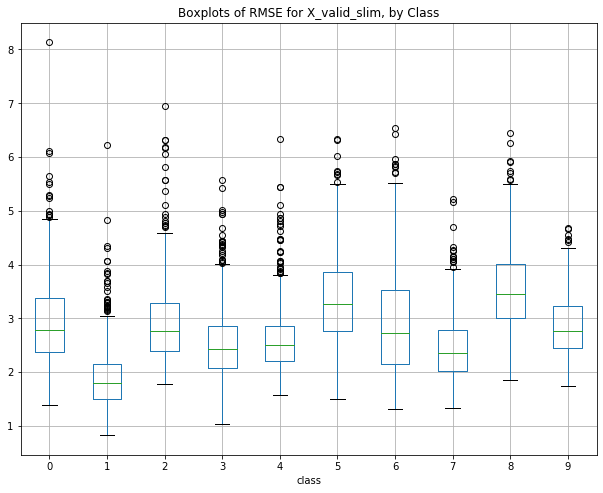

In [71]:
fig, ax = plt.subplots(figsize=(10,8))
df.boxplot(column=['euclidean'], by='class', ax=ax)
plt.title('Boxplots of RMSE for X_valid_slim, by Class')
plt.suptitle('')
plt.show()

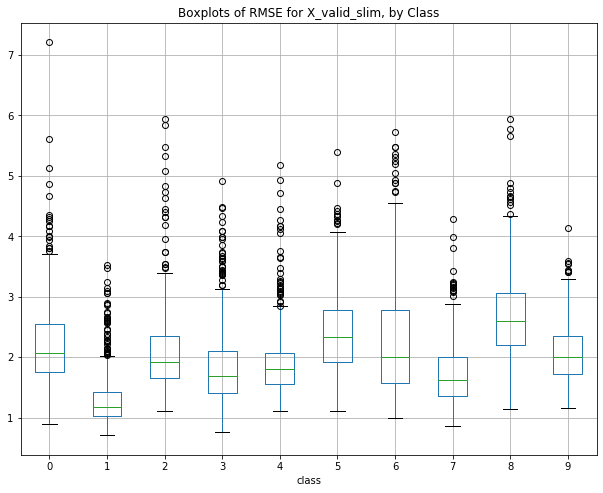

In [37]:
fig, ax = plt.subplots(figsize=(10,8))
df.boxplot(column=['euclidean'], by='class', ax=ax)
plt.title('Boxplots of RMSE for X_valid_slim, by Class')
plt.suptitle('')
plt.show()